In [46]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchvision import transforms
from PIL import Image
import requests
from io import BytesIO
import torchvision.models as models
import matplotlib.pyplot as plt
import numpy as np
import json
import urllib.request
import torchvision.datasets as datasets
import torchvision.models as models
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from torch.utils.data import DataLoader



In [47]:
model = models.resnet18(pretrained=True).eval()


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [48]:
transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])
unnorm = transforms.Normalize(mean=[-m/s for m, s in zip([0.485, 0.456, 0.406],
                                                         [0.229, 0.224, 0.225])],
                              std=[1/s for s in [0.229, 0.224, 0.225]])


In [49]:
def load_image_from_url(url):
    response = requests.get(url)
    img = Image.open(BytesIO(response.content)).convert('RGB')
    return img

def get_confidence_interval(image, model):
    with torch.no_grad():

        image_tensor = transform(image).unsqueeze(0)
        output = model(image_tensor)

        probabilities = F.softmax(output, dim=1)

        confidence, predicted_class = torch.max(probabilities, 1)
        confidence_interval = 1.96 * torch.std(probabilities) / torch.sqrt(torch.tensor(probabilities.size(1), dtype=torch.float32))

        return predicted_class.item(), confidence.item(), confidence_interval.item()


In [50]:
labels = "https://raw.githubusercontent.com/pytorch/hub/master/imagenet_classes.txt"
filename = "imagenet_classes.txt"
urllib.request.urlretrieve(labels, filename)

with open(filename, "r") as f:
    classes = [line.strip() for line in f.readlines()]



Classifying examples

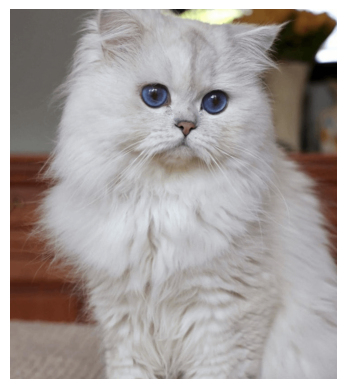

Predicted Label: 283 Persian cat
Confidence: 98.00%
Confidence Interval: ±0.19%


In [51]:
url = "https://preview.redd.it/do-you-prefer-a-silver-pompaws-persian-cat-with-blue-or-v0-o8ltjg7cps7d1.png?width=640&crop=smart&auto=webp&s=98767b43e93199f32cb4f7fe921780b50241438b"
image = load_image_from_url(url)


plt.imshow(image)
plt.axis('off')
plt.show()

# Predicted label and confidence interval
label_pred, confidence, confidence_interval = get_confidence_interval(image, model)

print(f"Predicted Label: {label_pred}", classes[label_pred])
print(f"Confidence: {confidence * 100:.2f}%")
print(f"Confidence Interval: ±{confidence_interval * 100:.2f}%")


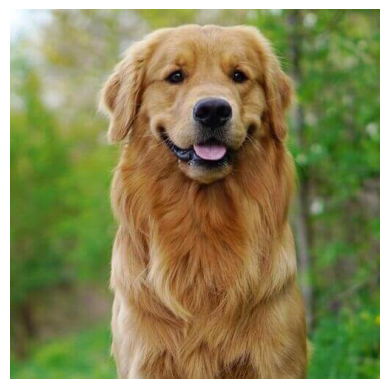

Predicted Label: 207 golden retriever
Confidence: 93.69%
Confidence Interval: ±0.18%


In [52]:
url2 = "https://www.vidavetcare.com/wp-content/uploads/sites/234/2022/04/golden-retriever-dog-breed-info.jpeg"
image2 = load_image_from_url(url2)

plt.imshow(image2)
plt.axis('off')
plt.show()

label_pred, confidence, confidence_interval = get_confidence_interval(image2, model)

print(f"Predicted Label: {label_pred}", classes[label_pred])
print(f"Confidence: {confidence * 100:.2f}%")
print(f"Confidence Interval: ±{confidence_interval * 100:.2f}%")

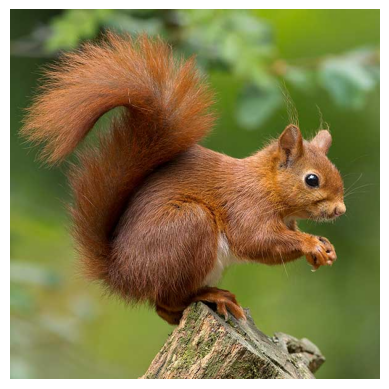

Predicted Label: 335 fox squirrel
Confidence: 98.59%
Confidence Interval: ±0.19%


In [53]:
url3 = "https://www.flapest.com/wp-content/uploads/2020/12/fox-squirrel.jpg"
image3 = load_image_from_url(url3)

plt.imshow(image3)
plt.axis('off')
plt.show()

label_pred, confidence, confidence_interval = get_confidence_interval(image3, model)


print(f"Predicted Label: {label_pred}", classes[label_pred])
print(f"Confidence: {confidence * 100:.2f}%")
print(f"Confidence Interval: ±{confidence_interval * 100:.2f}%")

In [54]:
original_image = image3.copy()
input_tensor = transform(image3).unsqueeze(0)

# One pixel attack

Modifying 1 pixel

In [55]:
def one_pixel_attack(image, model, h, w):

    image_tensor = transform(image).unsqueeze(0)
    img_tensor = unnorm(image_tensor.squeeze()).clamp(0, 1)
    img_np = img_tensor.permute(1, 2, 0).numpy()

    adv_img_np = img_np.copy()
    adv_img_np[h, w] = [0.0, 0.0, 1.0]

    adv_img_tensor = torch.tensor(adv_img_np).permute(2, 0, 1).float()
    adv_img_tensor = adv_img_tensor / torch.tensor([0.229, 0.224, 0.225]).view(3, 1, 1)
    adv_img_tensor = adv_img_tensor - torch.tensor([0.485, 0.456, 0.406]).view(3, 1, 1)
    adv_img_tensor = adv_img_tensor.unsqueeze(0)

    plt.imshow(adv_img_np)
    plt.axis('off')
    plt.show()


    with torch.no_grad():
        output = model(adv_img_tensor)
        probabilities = F.softmax(output, dim=1)
        confidence, predicted_class = torch.max(probabilities, 1)

    return predicted_class.item(), confidence.item()


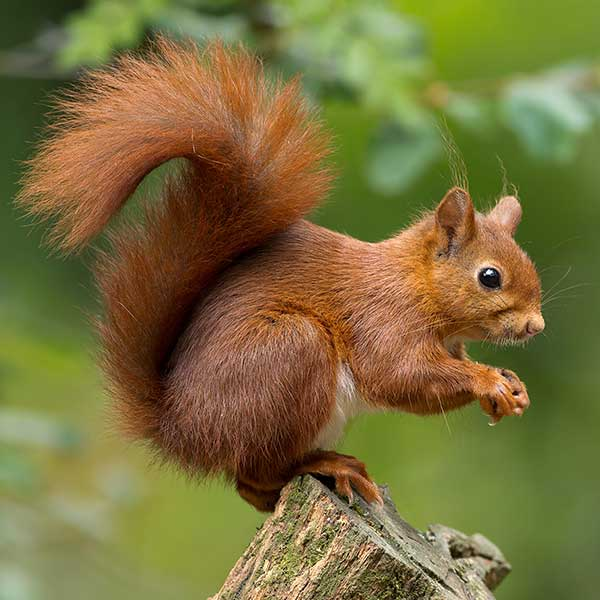

In [56]:
image_url = "https://www.flapest.com/wp-content/uploads/2020/12/fox-squirrel.jpg"
image = load_image_from_url(image_url)

display(image)


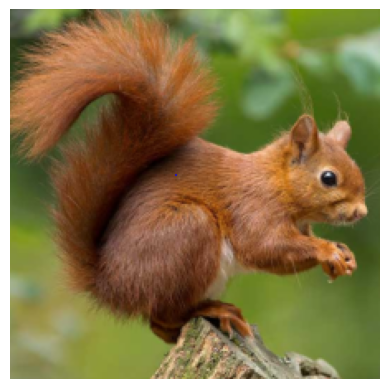

Predicted Label after attack: 335
Confidence after attack: 96.52%


In [57]:
h, w = 100, 100
attacked_label_pred, confidence = one_pixel_attack(image3, model, h, w)

# Print the results
print(f"Predicted Label after attack: {attacked_label_pred}")
print(f"Confidence after attack: {confidence * 100:.2f}%")

Using saliency map

In [58]:
def get_saliency_map(model, input_tensor, target_class=None):
    input_tensor = input_tensor.clone().detach().requires_grad_(True)
    model.zero_grad()

    output = model(input_tensor)
    pred_class = output.argmax(dim=1).item() if target_class is None else target_class

    output[0, pred_class].backward()
    saliency = input_tensor.grad.data.abs().squeeze().cpu()
    saliency, _ = torch.max(saliency, dim=0)
    return saliency.numpy(), pred_class

def one_pixel_attack_with_saliency(image, model):
    image_tensor = transform(image).unsqueeze(0)

    img_tensor = unnorm(image_tensor.squeeze()).clamp(0, 1)
    img_np = img_tensor.permute(1, 2, 0).numpy()

    saliency, pred_class = get_saliency_map(model, image_tensor)

    h, w = np.unravel_index(np.argmax(saliency), saliency.shape)

    adv_img_np = img_np.copy()
    adv_img_np[h, w] = [0.0, 0.0, 1.0]

    adv_img_tensor = torch.tensor(adv_img_np).permute(2, 0, 1).float()

    adv_img_tensor = adv_img_tensor / torch.tensor([0.229, 0.224, 0.225]).view(3, 1, 1)
    adv_img_tensor = adv_img_tensor - torch.tensor([0.485, 0.456, 0.406]).view(3, 1, 1)

    adv_img_tensor = adv_img_tensor.unsqueeze(0)

    plt.imshow(adv_img_np)
    plt.axis('off')
    plt.show()


    with torch.no_grad():
        output = model(adv_img_tensor)
        probabilities = F.softmax(output, dim=1)
        confidence, predicted_class = torch.max(probabilities, 1)

    return predicted_class.item(), confidence.item(), saliency


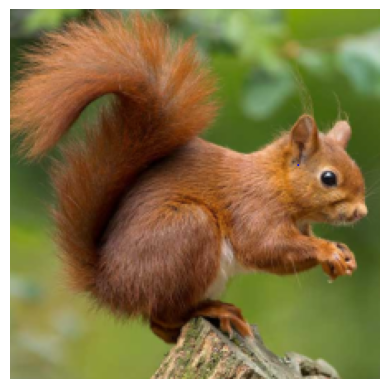

Predicted Label after attack: 335
Confidence after attack: 96.63%


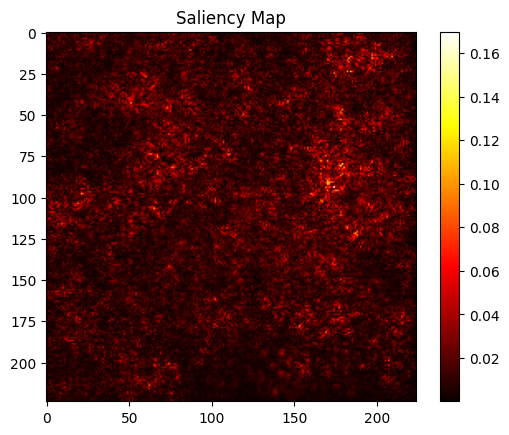

In [59]:
label_pred_sal, confidence, saliency_map = one_pixel_attack_with_saliency(image, model)

print(f"Predicted Label after attack: {label_pred_sal}")
print(f"Confidence after attack: {confidence * 100:.2f}%")

plt.imshow(saliency_map, cmap='hot')
plt.title("Saliency Map")
plt.colorbar()
plt.show()

# Multi-pixel attack

In [60]:
def multi_pixel_attack_with_saliency(image, model, num_pixels=2000):
    image_tensor = transform(image).unsqueeze(0)

    img_tensor = unnorm(image_tensor.squeeze()).clamp(0, 1)
    img_np = img_tensor.permute(1, 2, 0).numpy()

    saliency, pred_class = get_saliency_map(model, image_tensor)
    saliency_flat = saliency.flatten()
    top_indices = np.argsort(saliency_flat)[-num_pixels:]

    height, width = saliency.shape
    top_pixels = [(i // width, i % width) for i in top_indices]

    adv_img_np = img_np.copy()
    for h, w in top_pixels:
        adv_img_np[h, w] = [0.0, 0.0, 1.0]

    adv_img_tensor = torch.tensor(adv_img_np).permute(2, 0, 1).float()

    adv_img_tensor = adv_img_tensor / torch.tensor([0.229, 0.224, 0.225]).view(3, 1, 1)

    adv_img_tensor = adv_img_tensor - torch.tensor([0.485, 0.456, 0.406]).view(3, 1, 1)

    adv_img_tensor = adv_img_tensor.unsqueeze(0)

    plt.imshow(adv_img_np)
    plt.axis('off')  # Hide axes
    plt.show()

    with torch.no_grad():
        output = model(adv_img_tensor)
        probabilities = F.softmax(output, dim=1)
        confidence, predicted_class = torch.max(probabilities, 1)

    return predicted_class.item(), confidence.item(), saliency


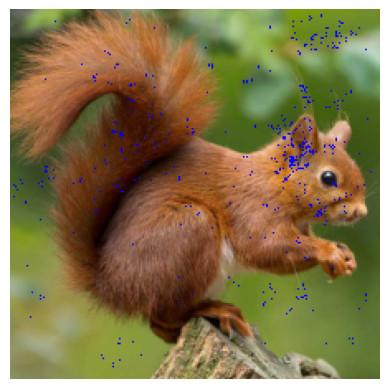

Predicted Label after attack: 335 hamster
Confidence after attack: 40.61%


In [61]:
image_url = "https://www.flapest.com/wp-content/uploads/2020/12/fox-squirrel.jpg"
image = load_image_from_url(image_url)

label_pred_multi, confidence, saliency_map = multi_pixel_attack_with_saliency(image, model, num_pixels=500)

print(f"Predicted Label after attack: {label_pred}", classes[label_pred_multi])
print(f"Confidence after attack: {confidence * 100:.2f}%")


In [62]:
def multi_pixel_attack(image, model, num_pixels=2000):

    image_tensor = transform(image).unsqueeze(0)
    img_tensor = unnorm(image_tensor.squeeze()).clamp(0, 1)
    img_np = img_tensor.permute(1, 2, 0).numpy()

    saliency, pred_class = get_saliency_map(model, image_tensor)

    flat_indices = np.argsort(saliency.ravel())[::-1][:num_pixels]
    coords = [np.unravel_index(idx, saliency.shape) for idx in flat_indices]

    adv_img_multi = img_np.copy()
    for coord in coords:
        adv_img_multi[coord] = [0.0, 0.0, 1.0]

    adv_tensor_multi = transforms.ToTensor()(adv_img_multi).unsqueeze(0)

    adv_tensor_multi = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                            std=[0.229, 0.224, 0.225])(adv_tensor_multi)
    plt.imshow(adv_img_multi)
    plt.title("Multi-Pixel Attack")
    plt.axis('off')
    plt.show()

    with torch.no_grad():
        adv_output_multi = model(adv_tensor_multi)
        adv_class_multi = adv_output_multi.argmax(dim=1).item()

    return adv_class_multi


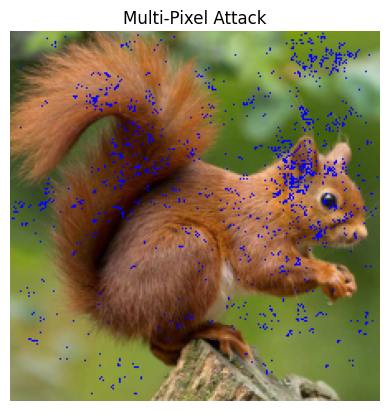

Multi-Pixel Attack Prediction: 696 paintbrush


In [63]:
image_url = "https://www.flapest.com/wp-content/uploads/2020/12/fox-squirrel.jpg"
image = load_image_from_url(image_url)
adv_class_multi = multi_pixel_attack(image, model, num_pixels=1500)
print("Multi-Pixel Attack Prediction:", adv_class_multi, classes[adv_class_multi])



# Multi pixel attack using Homemade classifier on MNIST dataset


In [64]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")



Using device: cuda


True Label: 1


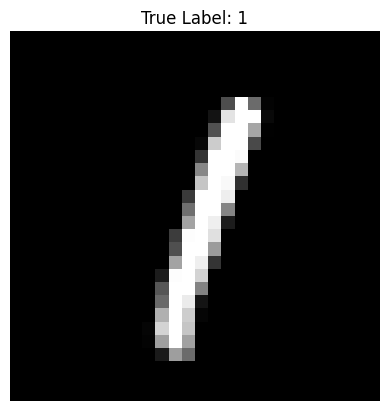

In [65]:
# MNIST transform
transform = transforms.Compose([
    transforms.ToTensor()
])

# Load test set
test_data = datasets.MNIST(root='./data', train=False, download=True, transform=transform)
img_tensor, label = test_data[5]
input_tensor = img_tensor.unsqueeze(0)
print("True Label:", label)

# Show the image
plt.imshow(img_tensor.squeeze(), cmap='gray')
plt.title(f"True Label: {label}")
plt.axis('off')
plt.show()


In [66]:
class HomemadeCNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Conv2d(1, 32, 3, padding=1),  # 28x28
            nn.ReLU(),
            nn.Conv2d(32, 64, 3, padding=1), # 28x28
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Flatten(),
            nn.Linear(64 * 14 * 14, 128),
            nn.ReLU(),
            nn.Linear(128, 10)
        )

    def forward(self, x):
        return self.net(x)


In [67]:
# Load MNIST
transform = transforms.ToTensor()
train_data = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
train_loader = DataLoader(train_data, batch_size=64, shuffle=True)

model = HomemadeCNN().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()

num_epochs = 5

model.train()
for epoch in range(num_epochs):
    for batch_idx, (data, target) in enumerate(train_loader):
        # Move data and target to the device
        data, target = data.to(device), target.to(device)

        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
    print(f"Epoch [{epoch + 1}/{num_epochs}] complete!")

print("Training complete!")


Epoch [1/5] complete!
Epoch [2/5] complete!
Epoch [3/5] complete!
Epoch [4/5] complete!
Epoch [5/5] complete!
Training complete!


True Label: 1


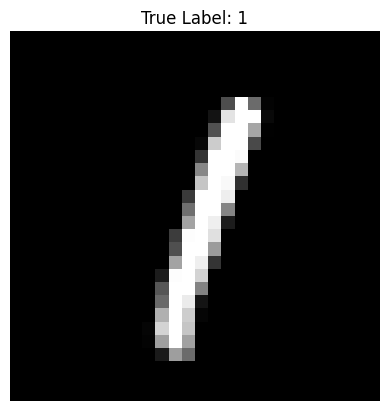

True Label: 1, Predicted: 1


In [68]:
test_data = datasets.MNIST(root='./data', train=False, download=True, transform=transform)
img_tensor, label = test_data[5]
input_tensor = img_tensor.unsqueeze(0)
print("True Label:", label)

plt.imshow(img_tensor.squeeze(), cmap='gray')
plt.title(f"True Label: {label}")
plt.axis('off')
plt.show()

input_tensor = input_tensor.to(device)

model.eval()
with torch.no_grad():
    pred = model(input_tensor).argmax(dim=1).item()
print(f"True Label: {label}, Predicted: {pred}")

In [69]:
gray_img = img_tensor.squeeze().numpy()

# Find 10 brightest pixels
flat = gray_img.flatten()
brightest_indices = np.argsort(flat)[-10:]
coords = [np.unravel_index(idx, (28, 28)) for idx in brightest_indices]

# grayscale to RGB
rgb_img = np.stack([gray_img]*3, axis=0)

#Attacking 10 bright pixels
for h, w in coords:
    rgb_img[0, h, w] = 1.0
    rgb_img[1, h, w] = 0.0
    rgb_img[2, h, w] = 0.0

adv_rgb_tensor = torch.tensor(rgb_img).unsqueeze(0).float().to(device)


In [70]:
# Assign the new Conv2d layer and move it to the device
model.net[0] = nn.Conv2d(3, 32, 3, padding=1).to(device)
model.eval()

HomemadeCNN(
  (net): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Flatten(start_dim=1, end_dim=-1)
    (6): Linear(in_features=12544, out_features=128, bias=True)
    (7): ReLU()
    (8): Linear(in_features=128, out_features=10, bias=True)
  )
)

In [71]:
with torch.no_grad():
    pred = model(adv_rgb_tensor).argmax(dim=1).item()
print("Prediction with 10 red dots on white parts:", pred)


Prediction with 10 red dots on white parts: 5


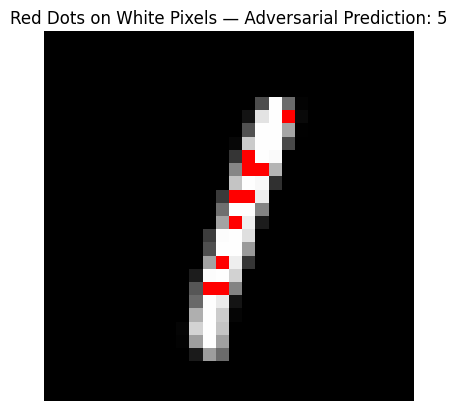

In [72]:
with torch.no_grad():
    adv_pred = model(adv_rgb_tensor).argmax(dim=1).item()

plt.imshow(np.transpose(rgb_img, (1, 2, 0)))
plt.title(f"Red Dots on White Pixels — Adversarial Prediction: {adv_pred}")
plt.axis('off')
plt.show()
